In [1]:
%matplotlib inline
import glob
import os
import matplotlib.pyplot as plt
import artm
import numpy as np
from matplotlib.artist import getp
import pandas as pd
import datetime

In [3]:
df = pd.read_csv('./data/preprocessed/df_textrank_clean_replace_more_13.csv')

/home/anisimova-anna/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3049: DtypeWarning: Columns (7,15) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [4]:
name = 'clean_replace_ent_text_textrank_more_13'
batch_folder = './{}_batches'.format(name)
data_path = './{}_vw.txt'.format(name)
dict_path = batch_folder + '/dictionary.dict'  

dic = artm.Dictionary()

if os.path.isfile(dict_path):
    dic.load(dictionary_path=dict_path)

    batch_vectorizer = artm.BatchVectorizer(data_path=data_path, 
                                    data_format='vowpal_wabbit', 
                                    collection_name='nthhappens', 
                                    target_folder=batch_folder)

In [5]:
n = 30
topic_names = ['topic_{}'.format(i) for i in range(n)]

In [6]:
def score_plot(plot_name, values, names, iter_cnt, last_values=None):
    fig = plt.figure(figsize = (10, 7))
    ax = fig.add_subplot(1,1,1) 
    colors = ['r', 'b', 'g', 'y', 'k', 'o'][:len(names)]
    markers = ['o', '*', '<', 'o', '*', '<'][:len(names)]

    for name, val, c, mark in zip(names, values, colors, markers):
        plt.plot(np.arange(0, iter_cnt, 1), val, c, linestyle='-', marker=mark, label=name)

    plt.legend(fontsize=18)
    plt.xlabel('Iteration number', fontsize=20)
    plt.ylabel(plot_name, fontsize=20)

    xticklabels = getp(plt.gca(), 'xticklabels')
    yticklabels = getp(plt.gca(), 'yticklabels')

    plt.setp(xticklabels, fontsize='large')
    plt.setp(yticklabels, fontsize='large')

    major_ticks_x = np.arange(0, iter_cnt - 1, 1)                                              
    minor_ticks_x = np.arange(0, iter_cnt - 1, 0.1)  
    if max(values[0])<= 1:
        step = 0.05
    else:
        step = 100
    major_ticks_y = np.arange(0, max(values[0]) + step * 2,  step * 2)                                              
    minor_ticks_y = np.arange(0, max(values[0]) +  step * 2, step)                                               

    ax.set_xticks(major_ticks_x)                                                       
    ax.set_xticks(minor_ticks_x, minor=True)   
    ax.set_yticks(major_ticks_y)                                                       
    ax.set_yticks(minor_ticks_y, minor=True) 

    ax.grid(which='both')                                                            

    ax.grid(which='minor', alpha=0.5)                                                
    ax.grid(which='major', alpha=1.0)
    
    if last_values:
        for name, last_val in zip(names, last_values):
            print(last_val, '\t', name)

In [7]:
def train_no_regular(class_ids, num_collection_passes=30, num_document_passes=5, pmt=0.3):
    # initialization
    model = artm.ARTM(topic_names=topic_names, cache_theta=True,
                       class_ids=class_ids,
                       scores=[artm.PerplexityScore(name='PerplexityScore',
                                                    dictionary=dic)])    
    # scores
    model.scores.add(artm.SparsityPhiScore(name='SparsityPhiScore'))
    model.scores.add(artm.SparsityThetaScore(name='SparsityThetaScore'))
    model.scores.add(artm.TopicKernelScore(name='TopicKernelScore', topic_names=topic_names,dictionary=dic,
                                                  probability_mass_threshold=pmt, class_id='@default_class'))
    model.scores.add(artm.TopTokensScore(name='TopTokensScore', num_tokens=10, 
                                         class_id='@default_class', dictionary=dic))

    # dictionary
    model.num_document_passes = num_document_passes
    model.initialize(dictionary=dic)

    #fit 1
    model.fit_offline(batch_vectorizer=batch_vectorizer, num_collection_passes=num_collection_passes)
    print('model fitted', ' ', datetime.datetime.now().time())
    return model

In [15]:
em_iter = 10
model_0_1 = train_no_regular({'@default_class': 1.0}, em_iter)
model_0_2 = train_no_regular({'@default_class': 1.0, '@textrank': 1.5}, em_iter)
model_0_3 = train_no_regular({'@default_class': 1.0, '@ents': 3.0}, em_iter)
model_0_4 = train_no_regular({'@default_class': 1.0, '@ents': 3.0, '@textrank': 1.5}, em_iter)

model fitted   02:22:16.448456
model fitted   02:23:20.912171
model fitted   02:24:17.566834
model fitted   02:25:23.335465


5478.77587890625 	 default_class
3959.863037109375 	 default + textrank 1.5
1239.2852783203125 	 default + entities 2.0
1354.2869873046875 	 default + textrank 1.5 + entities 2.0


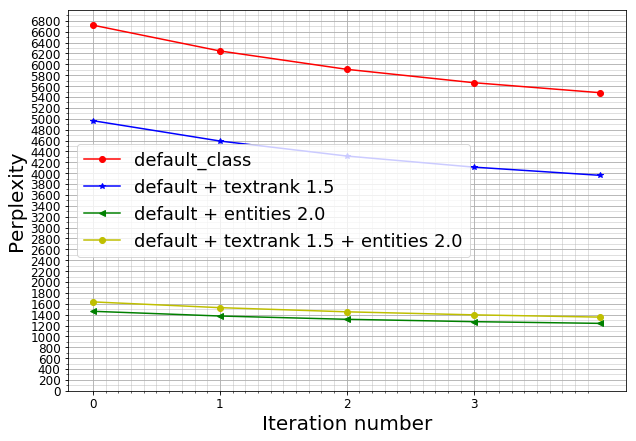

In [16]:
score_plot('Perplexity', 
           [
               model_0_1.score_tracker['PerplexityScore'].value[5:],
               model_0_2.score_tracker['PerplexityScore'].value[5:],
               model_0_3.score_tracker['PerplexityScore'].value[5:],
               model_0_4.score_tracker['PerplexityScore'].value[5:]
           ], 
           [
               'default_class',
               'default + textrank 1.5',
               'default + entities 3.0',
               'default + textrank 1.5 + entities 3.0'
           ],
          5,
           [
               model_0_1.score_tracker['PerplexityScore'].last_value,
               model_0_2.score_tracker['PerplexityScore'].last_value,
               model_0_3.score_tracker['PerplexityScore'].last_value,
               model_0_4.score_tracker['PerplexityScore'].last_value
           ]
          )

model_0_1.score_tracker['TopTokensScore'].average_coherence

3.182556611136533e-05 	 default_class
2.7279058485873975e-05 	 default + textrank 1.5
6.460829354182351e-06 	 default + entities 2.0
6.460829354182351e-06 	 default + textrank 1.5 + entities 2.0


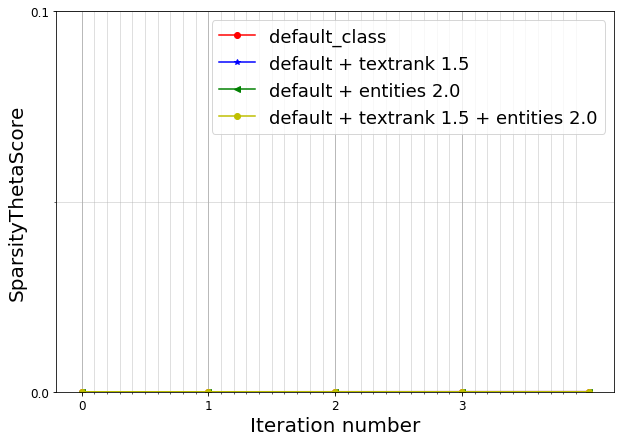

In [17]:
score_plot('SparsityThetaScore', 
           [
               model_0_1.score_tracker['SparsityThetaScore'].value[5:],
               model_0_2.score_tracker['SparsityThetaScore'].value[5:],
               model_0_3.score_tracker['SparsityThetaScore'].value[5:],
               model_0_4.score_tracker['SparsityThetaScore'].value[5:]
           ], 
           [
               'default_class',
               'default + textrank 1.5',
               'default + entities 3.0',
               'default + textrank 1.5 + entities 3.0'
           ],
          5,
           [
               model_0_1.score_tracker['SparsityThetaScore'].last_value,
               model_0_2.score_tracker['SparsityThetaScore'].last_value,
               model_0_3.score_tracker['SparsityThetaScore'].last_value,
               model_0_4.score_tracker['SparsityThetaScore'].last_value
           ]
          )

0.38627269864082336 	 default_class
0.3371579051017761 	 default + textrank 1.5
0.3457554578781128 	 default + entities 2.0
0.32961082458496094 	 default + textrank 1.5 + entities 2.0


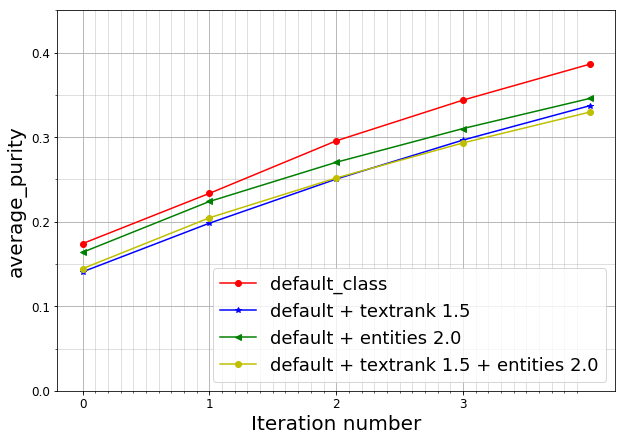

In [18]:
score_plot('average_purity', 
           [
               model_0_1.score_tracker['TopicKernelScore'].average_purity[5:],
               model_0_2.score_tracker['TopicKernelScore'].average_purity[5:],
               model_0_3.score_tracker['TopicKernelScore'].average_purity[5:],
               model_0_4.score_tracker['TopicKernelScore'].average_purity[5:]
           ], 
           [
               'default_class',
               'default + textrank 1.5',
               'default + entities 3.0',
               'default + textrank 1.5 + entities 3.0'
           ],
          5,
           [
               model_0_1.score_tracker['TopicKernelScore'].average_purity[-1],
               model_0_2.score_tracker['TopicKernelScore'].average_purity[-1],
               model_0_3.score_tracker['TopicKernelScore'].average_purity[-1],
               model_0_4.score_tracker['TopicKernelScore'].average_purity[-1]
           ]
          )

In [22]:
def train_default_regular(class_ids, num_collection_passes=30, num_document_passes=5, pmt=0.3):
    # initialization
    model = artm.ARTM(topic_names=topic_names, cache_theta=True,
                       class_ids=class_ids,
                       scores=[artm.PerplexityScore(name='PerplexityScore',
                                                    dictionary=dic)],
                     regularizers=[artm.SmoothSparseThetaRegularizer(
                         name='SparseTheta', tau=-0.2)])    
    # scores
    model.scores.add(artm.SparsityPhiScore(name='SparsityPhiScore'))
    model.scores.add(artm.SparsityThetaScore(name='SparsityThetaScore'))
    model.scores.add(artm.TopicKernelScore(name='TopicKernelScore', topic_names=topic_names,dictionary=dic,
                                                  probability_mass_threshold=pmt, class_id='@default_class'))
    model.scores.add(artm.TopTokensScore(name='TopTokensScore', num_tokens=10, 
                                         class_id='@default_class', dictionary=dic))
    #regularizers
    model.regularizers.add(artm.SmoothSparsePhiRegularizer(
                        name='SparsePhi', tau=-0.1, class_ids='@default_class'))
    model.regularizers.add(artm.DecorrelatorPhiRegularizer(
                        name='DecorrelatorPhi', tau=1.5e+5, class_ids='@default_class'))
    
    # dictionary
    model.num_document_passes = num_document_passes
    model.initialize(dictionary=dic)

    #fit 1
    model.fit_offline(batch_vectorizer=batch_vectorizer, num_collection_passes=num_collection_passes)
    print('model fitted', ' ', datetime.datetime.now().time())
    return model

In [23]:
def train_regulars(class_ids, num_collection_passes=30, num_document_passes=5, pmt=0.3):
    # initialization
    model = artm.ARTM(topic_names=topic_names, cache_theta=True,
                       class_ids=class_ids,
                       scores=[artm.PerplexityScore(name='PerplexityScore',
                                                    dictionary=dic)],
                     regularizers=[artm.SmoothSparseThetaRegularizer(
                         name='SparseTheta', tau=-0.2)])    
    # scores
    model.scores.add(artm.SparsityPhiScore(name='SparsityPhiScore'))
    model.scores.add(artm.SparsityThetaScore(name='SparsityThetaScore'))
    model.scores.add(artm.TopicKernelScore(name='TopicKernelScore', topic_names=topic_names,dictionary=dic,
                                                  probability_mass_threshold=pmt, class_id='@default_class'))
    model.scores.add(artm.TopTokensScore(name='TopTokensScore', num_tokens=10, 
                                         class_id='@default_class', dictionary=dic))
    
    model.scores.add(artm.SparsityPhiScore(name='SparsityScoreModal', class_id='@textrank'))
    #regularizers
    model.regularizers.add(artm.SmoothSparsePhiRegularizer(
                        name='SparsePhi', tau=-0.1, class_ids='@default_class'))
    model.regularizers.add(artm.DecorrelatorPhiRegularizer(
                        name='DecorrelatorPhi', tau=1.5e+5, class_ids='@default_class'))
    
    model.regularizers.add(artm.SmoothSparsePhiRegularizer(
                        name='SPPhiTextrankReg', tau=1.5e+5, class_ids='@textrank'))
    model.regularizers.add(artm.SmoothSparsePhiRegularizer(
                        name='SPPhiEntsReg', tau=1.5e+5, class_ids='@ents'))
    # dictionary
    model.num_document_passes = num_document_passes
    model.initialize(dictionary=dic)

    #fit 1
    model.fit_offline(batch_vectorizer=batch_vectorizer, num_collection_passes=num_collection_passes)
    print('model fitted', ' ', datetime.datetime.now().time())
    return model

In [21]:
em_iter = 20
model_1_0 = train_no_regular({'@default_class': 1.0}, em_iter)
model_1_1 = train_no_regular({'@default_class': 1.0, '@ents': 3.0, '@textrank': 1.5}, em_iter)

model fitted   02:32:18.744174
model fitted   02:34:40.150300


In [24]:
model_2 = train_default_regular({'@default_class': 1.0, '@ents': 3.0, '@textrank': 1.5}, 20)

model fitted   02:37:59.092667


In [25]:
model_3 = train_regulars({'@default_class': 1.0, '@ents': 3.0, '@textrank': 1.5}, 20)

model fitted   02:41:26.793272


4802.322265625 	 default_class
1204.4254150390625 	 default + textrank 1.5 + ents 2.0
1245.3912353515625 	 regular_default + textrank 1.5 + ents 3.0
3864.45654296875 	 regular_default + regular_textrank 1.5 + regular 3.0


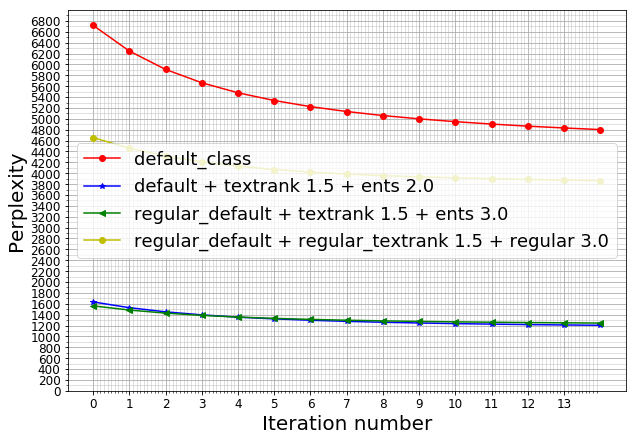

In [26]:
score_plot('Perplexity', 
           [
               model_1_0.score_tracker['PerplexityScore'].value[5:],
               model_1_1.score_tracker['PerplexityScore'].value[5:],
               model_2.score_tracker['PerplexityScore'].value[5:],
               model_3.score_tracker['PerplexityScore'].value[5:]
           ], 
           [
               'default_class',
               'default + textrank 1.5 + ents 2.0',
               'regular_default + textrank 1.5 + ents 3.0',
               'regular_default + regular_textrank 1.5 + regular 3.0'
           ],
          15,
           [
               model_1_0.score_tracker['PerplexityScore'].last_value,
               model_1_1.score_tracker['PerplexityScore'].last_value,
               model_2.score_tracker['PerplexityScore'].last_value,
               model_3.score_tracker['PerplexityScore'].last_value
           ]
          )

0.0005817139171995223 	 default_class
9.332309127785265e-05 	 default + textrank 1.5 + ents 2.0
0.6002258658409119 	 regular_default + textrank 1.5 + ents 3.0
0.5214705467224121 	 regular_default + regular_textrank 1.5 + regular 3.0


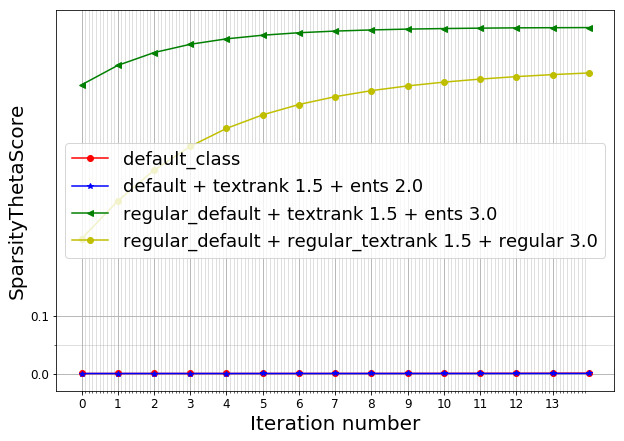

In [28]:
score_plot('SparsityThetaScore', 
           [
               model_1_0.score_tracker['SparsityThetaScore'].value[5:],
               model_1_1.score_tracker['SparsityThetaScore'].value[5:],
               model_2.score_tracker['SparsityThetaScore'].value[5:],
               model_3.score_tracker['SparsityThetaScore'].value[5:]
           ], 
           [
                'default_class',
               'default + textrank 1.5 + ents 2.0',
               'regular_default + textrank 1.5 + ents 3.0',
               'regular_default + regular_textrank 1.5 + regular 3.0'
           ],
          15,
           [
               model_1_0.score_tracker['SparsityThetaScore'].last_value,
               model_1_1.score_tracker['SparsityThetaScore'].last_value,
               model_2.score_tracker['SparsityThetaScore'].last_value,
               model_3.score_tracker['SparsityThetaScore'].last_value
           ]
          )

0.7750348448753357 	 default_class
0.7573857307434082 	 default + textrank 1.5 + ents 2.0
0.9510923624038696 	 regular_default + textrank 1.5 + ents 3.0
0.9586285352706909 	 regular_default + regular_textrank 1.5 + regular 3.0


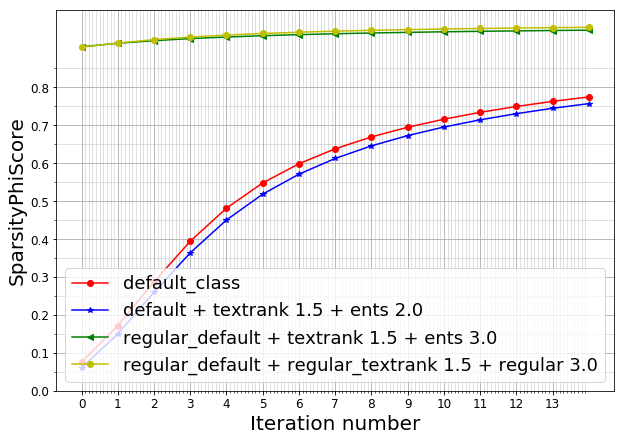

In [29]:
score_plot('SparsityPhiScore', 
           [
               model_1_0.score_tracker['SparsityPhiScore'].value[5:],
               model_1_1.score_tracker['SparsityPhiScore'].value[5:],
               model_2.score_tracker['SparsityPhiScore'].value[5:],
               model_3.score_tracker['SparsityPhiScore'].value[5:]
           ], 
           [
                 'default_class',
               'default + textrank 1.5 + ents 2.0',
               'regular_default + textrank 1.5 + ents 3.0',
               'regular_default + regular_textrank 1.5 + regular 3.0'
           ],
          15,
           [
               model_1_0.score_tracker['SparsityPhiScore'].last_value,
               model_1_1.score_tracker['SparsityPhiScore'].last_value,
               model_2.score_tracker['SparsityPhiScore'].last_value,
               model_3.score_tracker['SparsityPhiScore'].last_value
           ]
          )

0.5814674496650696 	 default_class
0.5179523229598999 	 default + textrank 1.5 + ents 2.0
0.5124922394752502 	 regular_default + textrank 1.5 + ents 3.0
0.6393130421638489 	 regular_default + regular_textrank 1.5 + regular 3.0


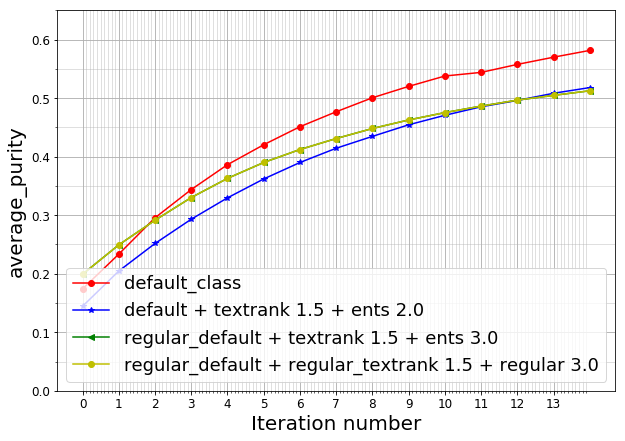

In [30]:
score_plot('average_purity', 
           [
               model_1_0.score_tracker['TopicKernelScore'].average_purity[5:],
               model_1_1.score_tracker['TopicKernelScore'].average_purity[5:],
               model_2.score_tracker['TopicKernelScore'].average_purity[5:],
               model_2.score_tracker['TopicKernelScore'].average_purity[5:]
           ], 
           [
                 'default_class',
               'default + textrank 1.5 + ents 2.0',
               'regular_default + textrank 1.5 + ents 3.0',
               'regular_default + regular_textrank 1.5 + regular 3.0'
           ],
          15,
           [
               model_1_0.score_tracker['TopicKernelScore'].average_purity[-1],
               model_1_1.score_tracker['TopicKernelScore'].average_purity[-1],
               model_2.score_tracker['TopicKernelScore'].average_purity[-1],
               model_3.score_tracker['TopicKernelScore'].average_purity[-1]
           ]
          )

9322.099609375 	 default_class
9328.0 	 default + textrank 1.5 + ents 2.0
7195.36669921875 	 regular_default + textrank 1.5 + ents 3.0
7059.533203125 	 regular_default + regular_textrank 1.5 + regular 3.0


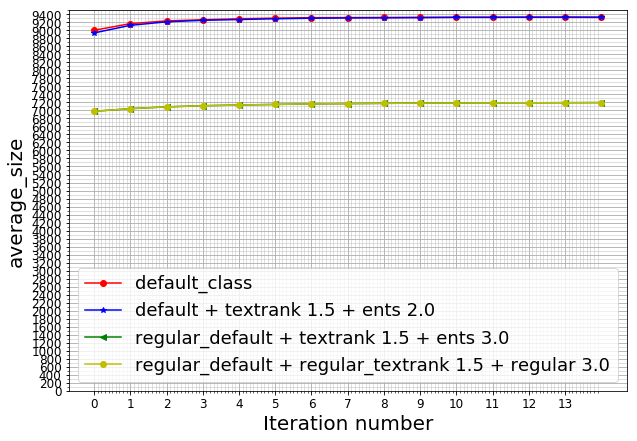

In [31]:
score_plot('average_size', 
           [
               model_1_0.score_tracker['TopicKernelScore'].average_size[5:],
               model_1_1.score_tracker['TopicKernelScore'].average_size[5:],
               model_2.score_tracker['TopicKernelScore'].average_size[5:],
               model_2.score_tracker['TopicKernelScore'].average_size[5:]
           ], 
           [
                 'default_class',
               'default + textrank 1.5 + ents 2.0',
               'regular_default + textrank 1.5 + ents 3.0',
               'regular_default + regular_textrank 1.5 + regular 3.0'
           ],
          15,
           [
               model_1_0.score_tracker['TopicKernelScore'].average_size[-1],
               model_1_1.score_tracker['TopicKernelScore'].average_size[-1],
               model_2.score_tracker['TopicKernelScore'].average_size[-1],
               model_3.score_tracker['TopicKernelScore'].average_size[-1]
           ]
          )

0.8554099202156067 	 default_class
0.8382704257965088 	 default + textrank 1.5 + ents 2.0
0.8791791200637817 	 regular_default + textrank 1.5 + ents 3.0
0.9267666935920715 	 regular_default + regular_textrank 1.5 + regular 3.0


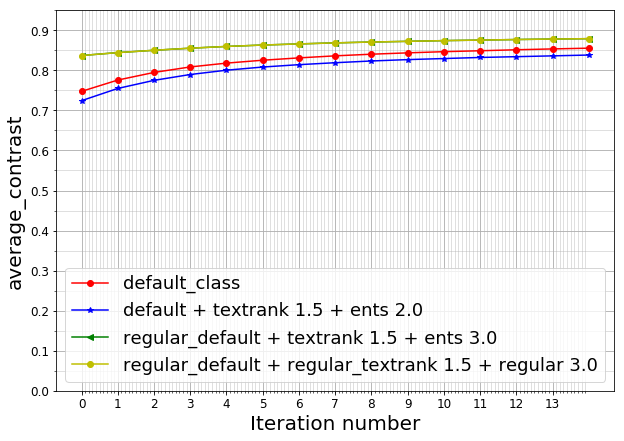

In [32]:
score_plot('average_contrast', 
           [
               model_1_0.score_tracker['TopicKernelScore'].average_contrast[5:],
               model_1_1.score_tracker['TopicKernelScore'].average_contrast[5:],
               model_2.score_tracker['TopicKernelScore'].average_contrast[5:],
               model_2.score_tracker['TopicKernelScore'].average_contrast[5:]
           ], 
           [
                 'default_class',
               'default + textrank 1.5 + ents 2.0',
               'regular_default + textrank 1.5 + ents 3.0',
               'regular_default + regular_textrank 1.5 + regular 3.0'
           ],
          15,
           [
               model_1_0.score_tracker['TopicKernelScore'].average_contrast[-1],
               model_1_1.score_tracker['TopicKernelScore'].average_contrast[-1],
               model_2.score_tracker['TopicKernelScore'].average_contrast[-1],
               model_3.score_tracker['TopicKernelScore'].average_contrast[-1]
           ]
          )

In [33]:
fin = model_3
for topic_name in fin.topic_names:
    print(topic_name + ': ', fin.score_tracker['TopTokensScore'].last_tokens[topic_name])
    print()

topic_0:  ['run', 'build', 'developers', 'development', 'platform', 'tools', 'running', 'projects', 'application', 'developer']

topic_1:  ['data', 'information', 'product', 'users', 'email', 'customers', 'link', 'call', 'news', 'marketing']

topic_2:  ['car', 'cars', 'drive', 'tesla', 'house', 'driving', 'traffic', 'safety', 'speed', 'train']

topic_3:  ['get', 'dont', 'youre', 'everyone', 'home', 'place', 'stop', 'local', 'getting', 'area']

topic_4:  ['first', 'day', 'days', 'food', 'second', 'water', 'minutes', 'week', 'time', 'times']

topic_5:  ['new', 'content', 'name', 'game', 'account', 'video', 'play', 'online', 'sites', 'popular']

topic_6:  ['business', 'company', 'laws', 'mean', 'industry', 'products', 'tech', 'law', 'case', 'must']

topic_7:  ['seems', 'process', 'probably', 'hand', 'project', 'team', 'make', 'wonder', 'actually', 'worked']

topic_8:  ['right', 'fact', 'agree', 'specific', 'useful', 'certain', 'means', 'cannot', 'context', 'may']

topic_9:  ['problem', 'h

In [37]:
fin = model_2
qwe = []
for topic_name in fin.topic_names:
    qwe.append({'topic_without_tuning': topic_name, 'top_without_tuning': fin.score_tracker['TopTokensScore'].last_tokens[topic_name]})

pd.options.display.max_colwidth = 3000

pd.DataFrame(qwe).iloc[16:]

,top_without_tuning,topic_without_tuning
16,"[work, job, jobs, city, live, working, employees, places, people, building]",topic_16
17,"[google, app, apple, facebook, windows, apps, amazon, phone, android, sure]",topic_17
18,"[take, thats, id, interesting, friends, sounds, dont, random, fun, guy]",topic_18
19,"[pay, worth, free, value, price, cost, paid, much, paying, k]",topic_19
20,"[design, url, source, designed, open_source, project, solution, create, blockchain, via]",topic_20
21,"[use, using, used, software, file, device, browser, hardware, password, client]",topic_21
22,"[first, right, service, services, second, ads, legal, privacy, law, allowed]",topic_22
23,"[true, power, government, political, despite, prevent, black, majority, false, vote]",topic_23
24,"[read, reading, book, good, ai, story, others, thing, books, happy]",topic_24
25,"[comment, understand, wrong, post, comments, see, understanding, discussion, correct, argument]",topic_25


In [34]:
fin = model_2
for topic_name in fin.topic_names:
    print(topic_name + ': ', fin.score_tracker['TopTokensScore'].last_tokens[topic_name])
    print()

topic_0:  ['build', 'team', 'developers', 'platform', 'work', 'application', 'tools', 'software', 'developer', 'built']

topic_1:  ['data', 'users', 'information', 'business', 'product', 'companies', 'company', 'url', 'customers', 'news']

topic_2:  ['years', 'car', 'days', 'year', 'today', 'back', 'day', 'last', 'cars', 'months']

topic_3:  ['system', 'way', 'hit', 'think', 'around', 'theres', 'instead', 'literally', 'dont', 'even']

topic_4:  ['time', 'hours', 'years_ago', 'minutes', 'water', 'age', 'remember', 'work', 'week', 'hour']

topic_5:  ['already', 'similar', 'since', 'content', 'want', 'game', 'video', 'play', 'continue', 'games']

topic_6:  ['local', 'laws', 'hn', 'eu', 'many', 'country', 'state', 'china', 'countries', 'uk']

topic_7:  ['enough', 'person', 'actually', 'perhaps', 'show', 'wonder', 'technical', 'ones', 'maybe', 'usually']

topic_8:  ['agree', 'gdpr', 'may', 'access', 'context', 'specific', 'shouldnt', 'cannot', 'reasonable', 'without']

topic_9:  ['problem',